# Session 2 — Data Modeling, ETL, and Cloud Architecture (AWS + Azure)

Understand how data models and ETL pipelines fit into modern cloud architectures on AWS and Azure.

## 📊 1️⃣ About Data Modeling

**Data modeling** defines how data is structured and related inside a database or data warehouse.

There are two common modeling patterns:

**⭐ Star Schema:** A central fact table connected to dimension tables.

**❄️ Snowflake Schema:** Dimensions are normalized into sub-dimensions to reduce duplication.

### Fact vs Dimension Tables

| Type | Purpose | Example |
|--|--|--|
| Fact | Stores metrics and measures | Sales transactions, Orders |
| Dimension | Descriptive attributes that add context | Customer, Product, Date, Region |

### Example SQL Structure
```sql
CREATE TABLE FactOrders (
  order_id INT PRIMARY KEY,
  customer_key INT,
  product_key INT,
  order_date DATE,
  quantity INT,
  amount DECIMAL(10, 2)
);

CREATE TABLE DimCustomer (
  customer_key INT PRIMARY KEY,
  customer_name TEXT,
  region TEXT
);

CREATE TABLE DimProduct (
  product_key INT PRIMARY KEY,
  product_name TEXT,
  category TEXT
);
```

## ⚙️ 2️⃣ ETL (Extract → Transform → Load)

ETL is the process of moving and preparing data for analytics.

| Stage | Description | Example |
|--|--|--|
| Extract | Pull data from sources | Read CSV or database table |
| Transform | Clean, filter, and enrich | Convert types, join data, aggregate |
| Load | Store data into target | Insert into warehouse table |

**ETL vs ELT:** ELT loads data first, then transforms inside the warehouse (Snowflake, Synapse, etc.).

In [24]:
import pandas as pd

# Extract
customers = pd.DataFrame({
    'customer_id': ['C101', 'C102', 'C103'],
    'name': ['Alice', 'Bob', 'Charlie'],
    'region': ['East', 'West', 'North']
})

orders = pd.DataFrame({
    'order_id': [1, 2, 3],
    'customer_id': ['C101', 'C102', 'C103'],
    'amount': [250.50, 175.00, 300.00]
})

# Transform
orders = orders.merge(customers, on='customer_id', how='left')

# Load (simulate writing to warehouse)
print("Loaded data:")
display(orders)

Loaded data:


,order_id,customer_id,amount,name,region
0,1,C101,250.5,Alice,East
1,2,C102,175.0,Bob,West
2,3,C103,300.0,Charlie,North


## 🔁 3️⃣ Full vs Incremental Loads

A **full load** refreshes the entire table each time. An **incremental load** only adds or updates new records since the last load.

Incremental loads reduce cost and time for large datasets.

In [25]:
import pandas as pd

day1 = pd.DataFrame({'order_id':[1,2,3],'amount':[200,150,100],'updated_at':['2025-10-22 10:00:00','2025-10-22 11:00:00','2025-10-22 12:00:00']})
day2 = pd.DataFrame({'order_id':[2,3,4],'amount':[175,120,90],'updated_at':['2025-10-23 09:00:00','2025-10-23 09:30:00','2025-10-23 10:00:00']})

# Full load
warehouse = day1.copy()
watermark = warehouse['updated_at'].max()

# Incremental: only load rows newer than watermark
new_data = day2[day2['updated_at'] > watermark]
warehouse = pd.concat([warehouse, new_data], ignore_index=True).drop_duplicates(subset=['order_id'], keep='last')

warehouse

,order_id,amount,updated_at
0,1,200,2025-10-22 10:00:00
3,2,175,2025-10-23 09:00:00
4,3,120,2025-10-23 09:30:00
5,4,90,2025-10-23 10:00:00


## ☁️ 4️⃣ Cloud Architecture Overview (AWS + Azure)

Modern data engineering relies on cloud platforms to handle data storage, processing, and analytics.

| Layer | Azure Component | AWS Component | Purpose |
|--|--|--|--|
| Storage | Azure Blob Storage / ADLS Gen2 | Amazon S3 | Store raw and processed data |
| Catalog / Meta | Azure Purview | AWS Glue Data Catalog | Discover and manage data assets |
| Compute / Processing | Azure Databricks, Synapse Spark | AWS Glue, EMR | Data transformation and ETL |
| Orchestration | Azure Data Factory | AWS Step Functions, MWAA | Schedule and monitor ETL jobs |
| Warehouse | Azure Synapse Analytics | Amazon Redshift | Analytical data store |
| Serverless SQL | Synapse Serverless | AWS Athena | Query data in the data lake |
| Streaming | Azure Event Hubs | Amazon Kinesis | Real-time data ingestion |
| Functions | Azure Functions | AWS Lambda | Lightweight compute tasks |
| Secrets / Config | Azure Key Vault | AWS Secrets Manager | Secure credentials |
| BI / Visualization | Power BI | Amazon QuickSight | Dashboards and analytics |

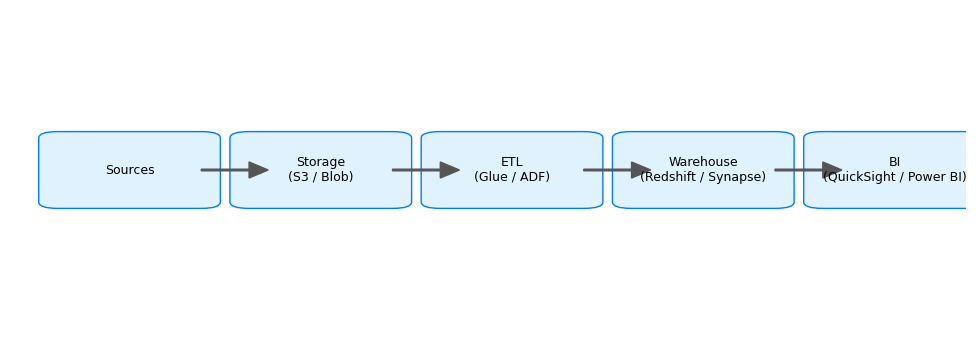

In [26]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrow

fig, ax = plt.subplots(figsize=(10, 3.5))
ax.axis("off")

def box(x, text):
    ax.add_patch(FancyBboxPatch((x, 0.4), 0.15, 0.2,
                                boxstyle="round,pad=0.02",
                                fc="#e0f2fe", ec="#007aff"))
    ax.text(x + 0.075, 0.5, text, ha="center", va="center", fontsize=9)

# ✅ Use explicit '\n' for line breaks inside labels
labels = [
    "Sources",
    "Storage\n(S3 / Blob)",
    "ETL\n(Glue / ADF)",
    "Warehouse\n(Redshift / Synapse)",
    "BI\n(QuickSight / Power BI)"
]

for i, l in enumerate(labels):
    box(0.05 + i * 0.2, l)

for i in range(4):
    ax.add_patch(FancyArrow(0.2 + i * 0.2, 0.5, 0.05, 0,
                            head_width=0.05, head_length=0.02,
                            width=0.005, color="#555"))

plt.tight_layout()
plt.show()


## ⏱️ 5️⃣ Job Scheduling and Monitoring

Once data pipelines are designed and tested, they need to run automatically and reliably.  
This is where **job scheduling** and **monitoring** become essential parts of a data engineering workflow.

---

### 🕒 What is Job Scheduling?

Job scheduling means defining **when, how often, and in what order** data processes should run.  
Schedulers ensure that ETL jobs, transformations, and data quality checks happen consistently without manual effort.

#### 💡 Key Concepts:
- **Triggers:** Specify *when* a job should start — time-based (every hour, daily @ 2 AM) or event-based (new file uploaded).
- **Dependencies:** Define *what order* tasks should run in — for example, load customers **before** loading orders.
- **Retries and Alerts:** Handle transient failures automatically and notify engineers if something breaks.
- **Concurrency Control:** Prevent overlapping runs when a previous job hasn’t finished.
- **Parameterization:** Pass dynamic values such as execution date or file paths into each job.

#### 🧩 Examples:
| Scheduler | Description |
|------------|--------------|
| **Apache Airflow** | Open-source workflow orchestrator for complex DAG-based scheduling. |
| **Azure Data Factory Triggers** | Schedule pipelines at fixed intervals or upon external events. |
| **AWS Glue Workflows / Step Functions** | Manage ETL job dependencies and state across AWS services. |
| **Cron jobs / Linux Scheduler** | Simple time-based scheduling for scripts or local tasks. |

---

### 📈 Monitoring and Observability

Monitoring ensures that pipelines are not only running, but producing correct results within expected time and cost.

#### 🧠 What to Monitor:
- **Pipeline Status:** Success, failure, or skipped runs.  
- **Execution Time:** Detect performance degradation or long-running jobs.  
- **Data Volume and Quality:** Track row counts, null values, and validation errors.  
- **Costs and Resource Usage:** Especially important in cloud environments (compute / storage / network).  

#### 📊 Monitoring Tools:
| Platform | Monitoring Feature |
|-----------|--------------------|
| **Airflow UI / Logs** | Task-level logs, retry counts, execution graphs. |
| **Azure Monitor + ADF Run History** | Pipeline runs, trigger details, alert rules. |
| **AWS CloudWatch / Glue Metrics** | Track job duration, success rates, and errors. |
| **Custom Dashboards (Grafana / Prometheus)** | Centralized monitoring across multiple systems. |

---

### ⚙️ Best Practices
1. **Modularize Tasks** → Break pipelines into smaller, reusable steps.  
2. **Set Clear SLAs** → Define acceptable completion times and alert thresholds.  
3. **Enable Logging and Auditing** → Keep execution history for debugging and compliance.  
4. **Automate Failure Recovery** → Use retries and fallback paths to handle intermittent errors.  
5. **Visualize Metrics** → Integrate pipeline health into your team’s dashboards.

---

Once these foundations are understood, you can explore specific tools like **Airflow**, **Azure Data Factory**, and **AWS Glue** to implement reliable, observable pipelines in production.


## 💡 6️⃣ Practice / Capstone Tasks

1️⃣ Design a star schema for a Retail Orders dataset.

2️⃣ Implement an incremental load in Python using `updated_at`.

3️⃣ Draw your own data pipeline diagram showing AWS and Azure equivalents.

4️⃣ (Advanced) Use SQLite to store Fact and Dimension tables and run queries for KPIs.